# Preprocess tracks from PostgreSQL

In [ ]:
import pandas as pd
import numpy as np
from pandarallel import pandarallel

pandarallel.initialize()
from tqdm.auto import tqdm
tqdm.pandas()

In [ ]:
raw_dataset = pd.read_csv("data/12_02_2021.csv")
raw_dataset.head()

In [ ]:
def process_df(df):

    lats = df.lats
    lats = lats[1:-1].split(',')
    df.lats = np.array(lats).astype(np.float32)

    lngs = df.lngs
    lngs = lngs[1:-1].split(',')
    df.lngs = np.array(lngs).astype(np.float32)

    speeds = df.speeds
    speeds = speeds[1:-1].split(',')
    df.speeds = np.array(speeds).astype(np.uint8)

    direction = df.direction
    direction = direction[1:-1].split(',')
    df.direction = np.array(direction).astype(np.uint8)

    ts = df.ts
    ts = ts[1:-1].split(',')
    df.ts = np.array(ts).astype(np.uint)

    return df

In [ ]:
dataset = raw_dataset.parallel_apply(process_df, axis=1)

In [ ]:
dataset.head()
# https://github.com/jmcarpenter2/swifter/

In [ ]:
# dataset.to_csv('data/preprocessed_dataset.csv')

# Split to small tracks

In [ ]:
import pandas as pd
import numpy as np
import geopy.distance as distance

In [ ]:
def split_tracks(df):
    splitted_tracks = []
    
    speeds = df.speeds[::-1]
    ts = df.ts[::-1]
    lats = df.lats[::-1]
    lons = df.lngs[::-1]

    prev_start = 0
    dist = 0
    for i in range(1, len(lats)):
        new_dist = distance.great_circle( (lats[i-1], lons[i-1]), (lats[i], lons[i]) ).km
        
        if (dist + new_dist) < 2:
            dist += new_dist
            continue
        
        track = [ lats[prev_start:i], lons[prev_start:i], ts[prev_start:i], speeds[prev_start:i], dist*1000, i - prev_start ]
        prev_start = i
        dist = 0
        
        splitted_tracks.append(track)
        
    return pd.DataFrame(splitted_tracks)

In [ ]:
split_dataset = dataset.parallel_apply(split_tracks, axis=1)

In [ ]:
corrected_dataset = pd.concat(split_dataset.to_list())

In [ ]:
corrected_dataset.head()

In [ ]:
corrected_dataset.to_csv("data/processed_tracks.csv")

In [ ]:
import pickle as pkl
import os

In [ ]:
path = "/home/rami/Desktop/sd_maps/routing/collected_ds"

In [ ]:
os.listdir(path)

In [ ]:
with open(os.path.join(path, "train-data_2020-09-19T17:21:56.972509.pkl"), 'rb') as fname :
    train_data = pkl.load(fname)

In [ ]:
pd.DataFrame(train_data).head()

# Old RFR approach

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pickle as pkl

import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics


import os
dir_name = "/home/rami/Desktop/sd_maps/routing/collected_ds"

%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
rcParams["errorbar.capsize"] = 5

In [2]:
osrm_error = []
pred_error = []

osrm_std = []
pred_std = []

full_train_data = []
full_labels = pd.DataFrame(columns=["ya_dur", "osrm_dur", "dist"])

timestamps = []
ts_labels = []
fnames = os.listdir(dir_name)
fnames.sort()
for name in fnames:
    if name[-3:] != "csv":
        with open(os.path.join(dir_name, name), "rb") as f:
            full_train_data.extend(pkl.load(f))
        continue
    
    labels = pd.read_csv(os.path.join(dir_name, name))
    osrm_error.append(np.mean(labels.ya_dur - labels.osrm_dur))
    osrm_std.append(np.std(labels.ya_dur - labels.osrm_dur))
    
    pred_error.append(np.mean(labels.ya_dur - labels.pred))
    pred_std.append(np.std(labels.ya_dur - labels.pred))
    
    ts_srt = name[:-4]
    ts_srt = ts_srt.split("_")[1]
    ts = datetime.strptime(ts_srt, '%Y-%m-%dT%H:%M:%S.%f')
    # timestamps.append( f"{ts.day}.{ts.month} {ts.hour}:{ts.minute}" )
    timestamps.append(datetime.strptime(ts_srt, '%Y-%m-%dT%H:%M:%S.%f'))
    ts_labels.append( f"{ts.day}.{ts.month} {ts.hour}:{ts.minute}" )
    
    full_labels = full_labels.append( labels[["ya_dur", "osrm_dur", "dist"]], ignore_index=1 )
    
stats = pd.DataFrame( {"osrm_error": osrm_error, "osrm_std": osrm_std, "pred_error": pred_error, "pred_std": pred_std, "timestamp": timestamps, "ts_labels": ts_labels} )
stats = stats.sort_values("timestamp")

#with open("full_data_regr.pkl", "rb") as f:
#    regressor = pkl.load(f)

#with open("rfr_mb_nice.pkl", "rb") as f:
#    old_regressor = pkl.load(f)
    
#full_labels["new_regr_pred"] = regressor.predict(full_train_data)
#full_labels["old_pred"] = old_regressor.predict(full_train_data)

In [3]:
full_labels

,ya_dur,osrm_dur,dist
0,41.561933,35.213333,31.489
1,51.455894,53.161667,58.064
2,45.824583,42.710000,49.139
3,19.408894,7.653333,5.306
4,34.550419,32.640000,39.779
...,...,...,...
147986,46.248957,43.398333,51.410
147987,53.369956,52.823333,64.818
147988,45.173141,41.486667,52.569
147989,34.569927,24.561667,17.074


In [4]:
X = pd.DataFrame(data=full_train_data, columns=["osrm", "distance", "n_slow", "n_medium", "n_fast", "n_free"])

In [5]:
dataset = df_concat = pd.concat([full_labels, X], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, dataset["ya_dur"], test_size=0.2, random_state=0)

In [7]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [28]:
regr = RandomForestRegressor(max_depth=3, n_estimators=50, random_state=2310, n_jobs=8, verbose=3, criterion="mae")

In [29]:
regr.fit(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  3.0min


building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed: 11.1min finished


RandomForestRegressor(criterion='mae', max_depth=3, n_estimators=50, n_jobs=8,
                      random_state=2310, verbose=3)

In [30]:
y_pred = regr.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


In [31]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 5.553921084834444
Mean Squared Error: 74.09636669321927
Root Mean Squared Error: 8.607924644954744


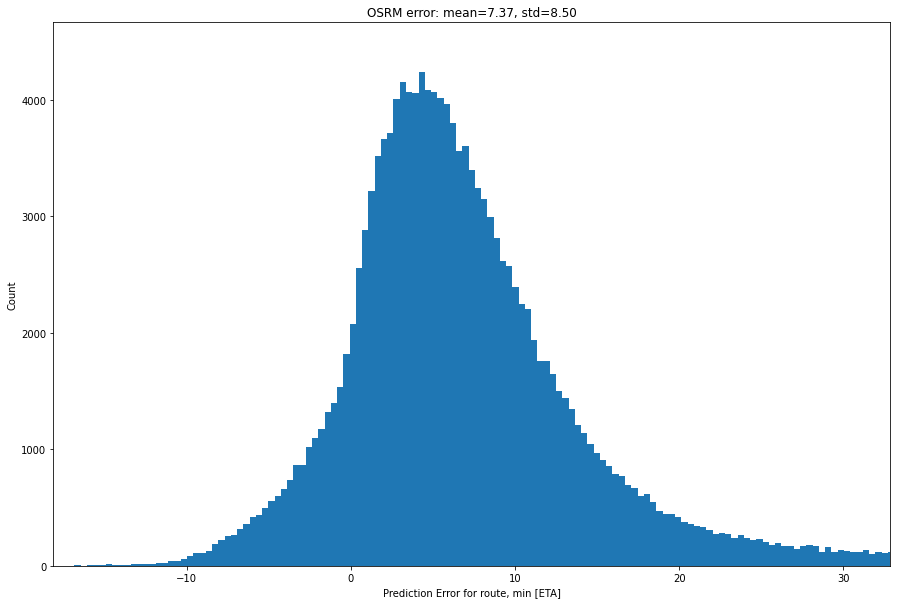

In [32]:
error = np.array(full_labels.ya_dur) - np.array(full_labels.osrm_dur)
std = np.std(error)
mean = np.mean(error)
cals, vals = np.histogram(error, bins = 500)
plt.hist(error, bins = 500)
plt.ylim(0, max(cals)*1.1)
plt.xlim(-std*3 + mean, std*3 +  mean)
plt.xlabel("Prediction Error for route, min [ETA]")
plt.title(f"OSRM error: mean={mean:.2f}, std={std:.2f}")
_ = plt.ylabel("Count")

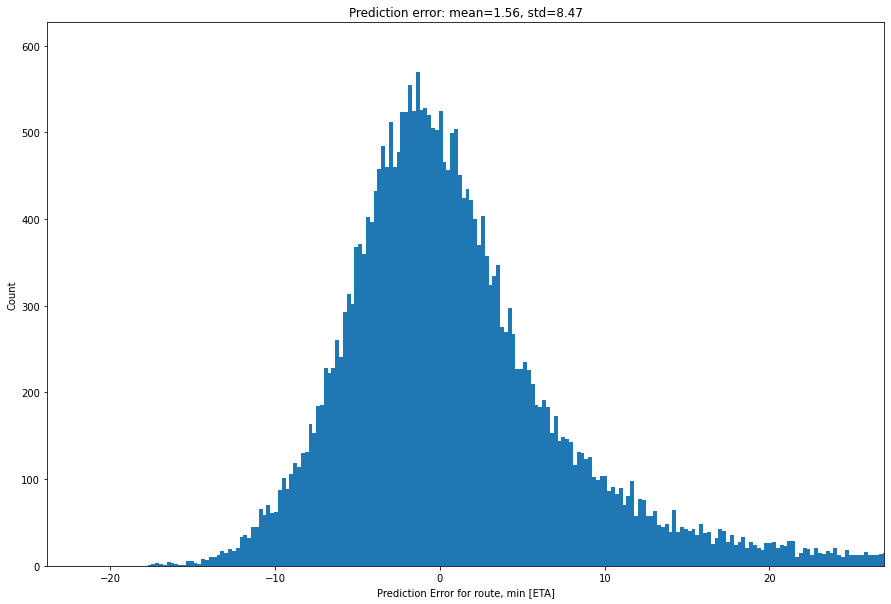

In [33]:
error = np.array(y_test) - np.array(y_pred)
std = np.std(error)
mean = np.mean(error)
cals, vals = np.histogram(error, bins = 500)
plt.hist(error, bins = 500)
plt.ylim(0, max(cals)*1.1)
plt.xlim(-std*3 + mean, std*3 +  mean)
plt.xlabel("Prediction Error for route, min [ETA]")
plt.title(f"Prediction error: mean={mean:.2f}, std={std:.2f}")
_ = plt.ylabel("Count")